In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder as SparkOneHotEncoder
from pyspark.ml.regression import LinearRegression as SparkLinearRegression
from pyspark.ml.classification import LogisticRegression as SparkLogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline as SparkPipeline
import ast
import os

In [ ]:
df = pd.read_csv("zomato_df_final_data.csv")
df

,address,cost,cuisine,lat,link,lng,phone,rating_number,rating_text,subzone,title,type,votes,groupon,color,cost_2,cuisine_color
0,"371A Pitt Street, CBD, Sydney",50.0,"['Hot Pot', 'Korean BBQ', 'BBQ', 'Korean']",-33.876059,https://www.zomato.com/sydney/sydney-madang-cbd,151.207605,02 8318 0406,4.0,Very Good,CBD,Sydney Madang,['Casual Dining'],1311.0,False,#e15307,5.243902,#6f706b
1,"Shop 7A, 2 Huntley Street, Alexandria, Sydney",80.0,"['Cafe', 'Coffee and Tea', 'Salad', 'Poké']",-33.910999,https://www.zomato.com/sydney/the-grounds-of-a...,151.193793,02 9699 2225,4.6,Excellent,"The Grounds of Alexandria, Alexandria",The Grounds of Alexandria Cafe,['Café'],3236.0,False,#9c3203,7.560976,#6f706b
2,"Level G, The Darling at the Star, 80 Pyrmont ...",120.0,['Japanese'],-33.867971,https://www.zomato.com/sydney/sokyo-pyrmont,151.195210,1800 700 700,4.9,Excellent,"The Star, Pyrmont",Sokyo,['Fine Dining'],1227.0,False,#7f2704,10.650407,#6f706b
3,"Sydney Opera House, Bennelong Point, Circular...",270.0,['Modern Australian'],-33.856784,https://www.zomato.com/sydney/bennelong-restau...,151.215297,02 9240 8000,4.9,Excellent,Circular Quay,Bennelong Restaurant,"['Fine Dining', 'Bar']",278.0,False,#7f2704,22.235772,#4186f4
4,"20 Campbell Street, Chinatown, Sydney",55.0,"['Thai', 'Salad']",-33.879035,https://www.zomato.com/sydney/chat-thai-chinatown,151.206409,02 8317 4811,4.5,Excellent,Chinatown,Chat Thai,['Casual Dining'],2150.0,False,#a83703,5.630081,#6f706b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,"40 Station Street, Wentworthville, Parramatta...",40.0,['Chinese'],-33.808653,https://www.zomato.com/sydney/cozy-resturant-p...,150.972147,02 9636 3502,NaN,NaN,Parramatta,Cozy Resturant,['Casual Dining'],NaN,False,#000000,4.471545,#f45042
10496,"143 Haldon Street, Lakemba, Sydney",20.0,['Beverages'],-33.922147,https://www.zomato.com/sydney/lakemba-hotel-la...,151.078400,Not available for this place,NaN,NaN,Lakemba,Lakemba Hotel,['Bar'],NaN,False,#000000,2.926829,#6f706b
10497,"Jordan Springs Woolworths Shopping Centre, Jo...",20.0,['Sushi'],-33.726993,https://www.zomato.com/sydney/sushi-yogho-penrith,150.725143,Not available for this place,NaN,NaN,Penrith,Sushi Yogho,['Food Court'],NaN,False,#000000,2.926829,#6f706b
10498,"St Mary's Village, Charles Hackett Drive, St ...",15.0,['Sushi'],-33.766770,https://www.zomato.com/sydney/kota-sushi-1-st-...,150.769962,0416 888 777,NaN,NaN,St Marys,Kota Sushi,['Food Court'],NaN,False,#000000,2.540650,#6f706b


In [ ]:
df_j = pd.read_json("sydney .geojson")
df_j

,type,features
0,FeatureCollection,"{'type': 'Feature', 'properties': {'SSC_CODE':..."
1,FeatureCollection,"{'type': 'Feature', 'properties': {'SSC_CODE':..."
2,FeatureCollection,"{'type': 'Feature', 'properties': {'SSC_CODE':..."
3,FeatureCollection,"{'type': 'Feature', 'properties': {'SSC_CODE':..."
4,FeatureCollection,"{'type': 'Feature', 'properties': {'SSC_CODE':..."
...,...,...
489,FeatureCollection,"{'type': 'Feature', 'properties': {'SSC_CODE':..."
490,FeatureCollection,"{'type': 'Feature', 'properties': {'SSC_CODE':..."
491,FeatureCollection,"{'type': 'Feature', 'properties': {'SSC_CODE':..."
492,FeatureCollection,"{'type': 'Feature', 'properties': {'SSC_CODE':..."


In [ ]:
df.shape

(10500, 17)

In [ ]:
df_j.shape

(494, 2)

In [ ]:
df.isnull().sum()

address             0
cost              346
cuisine             0
lat               192
link                0
lng               192
phone               0
rating_number    3316
rating_text      3316
subzone             0
title               0
type               48
votes            3316
groupon             0
color               0
cost_2            346
cuisine_color       0
dtype: int64

In [ ]:
df_j.isnull().sum()

type        0
features    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        10500 non-null  object 
 1   cost           10154 non-null  float64
 2   cuisine        10500 non-null  object 
 3   lat            10308 non-null  float64
 4   link           10500 non-null  object 
 5   lng            10308 non-null  float64
 6   phone          10500 non-null  object 
 7   rating_number  7184 non-null   float64
 8   rating_text    7184 non-null   object 
 9   subzone        10500 non-null  object 
 10  title          10500 non-null  object 
 11  type           10452 non-null  object 
 12  votes          7184 non-null   float64
 13  groupon        10500 non-null  bool   
 14  color          10500 non-null  object 
 15  cost_2         10154 non-null  float64
 16  cuisine_color  10500 non-null  object 
dtypes: bool(1), float64(6), object(10)
memory usage: 1

In [ ]:
df_j.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   type      494 non-null    object
 1   features  494 non-null    object
dtypes: object(2)
memory usage: 7.8+ KB


In [ ]:
unique_cuisines = df['cuisine'].nunique()
print("Number of unique cuisines served:", unique_cuisines)

cuisine_list = df['cuisine'].unique()
print("Cuisines:", cuisine_list)

Number of unique cuisines served: 1759
Cuisines: ["['Hot Pot', 'Korean BBQ', 'BBQ', 'Korean']"
 "['Cafe', 'Coffee and Tea', 'Salad', 'Poké']" "['Japanese']" ...
 "['Bakery', 'Pizza', 'Kebab']" "['Cafe', 'Coffee and Tea', 'Chinese']"
 "['Kebab', 'Burger', 'Fish and Chips']"]


In [ ]:
print(df[['subzone', 'title']].head())
top_subzones = df['subzone'].value_counts().head(3)
print("Top 3 subzones with the most restaurants:")
print(top_subzones)


                                 subzone                           title
0                                    CBD                   Sydney Madang
1  The Grounds of Alexandria, Alexandria  The Grounds of Alexandria Cafe
2                      The Star, Pyrmont                           Sokyo
3                          Circular Quay            Bennelong Restaurant
4                              Chinatown                       Chat Thai
Top 3 subzones with the most restaurants:
subzone
CBD            476
Surry Hills    260
Parramatta     225
Name: count, dtype: int64


In [ ]:
subset = df[df['rating_text'].isin(['Excellent', 'Poor'])]

mean_cost = subset.groupby('rating_text')['cost'].mean()
print("Average cost by rating:")
print(mean_cost)

Average cost by rating:
rating_text
Excellent    101.666667
Poor          55.845771
Name: cost, dtype: float64


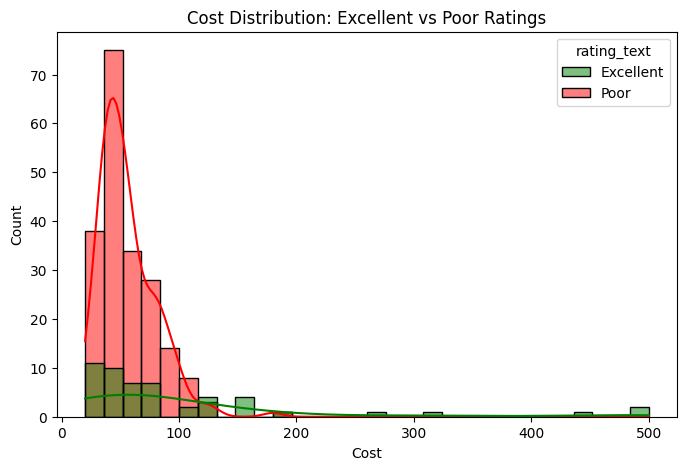

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data=subset, x='cost', hue='rating_text', kde=True, bins=30, palette={'Excellent':'green','Poor':'red'})
plt.title("Cost Distribution: Excellent vs Poor Ratings")
plt.xlabel("Cost")
plt.ylabel("Count")
plt.show()

C:\Users\IQ\AppData\Local\Temp\ipykernel_26968\131298965.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='rating_text', y='cost', palette={'Excellent':'green','Poor':'red'})


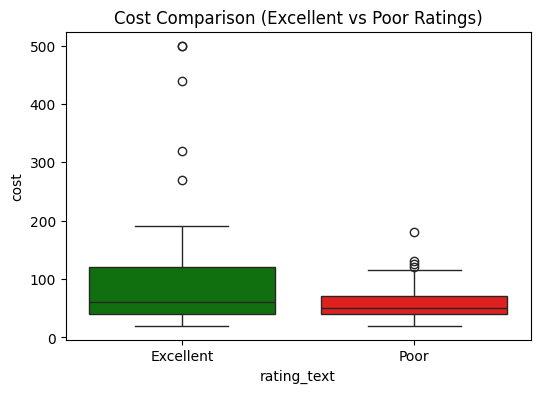

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(data=subset, x='rating_text', y='cost', palette={'Excellent':'green','Poor':'red'})
plt.title("Cost Comparison (Excellent vs Poor Ratings)")
plt.show()

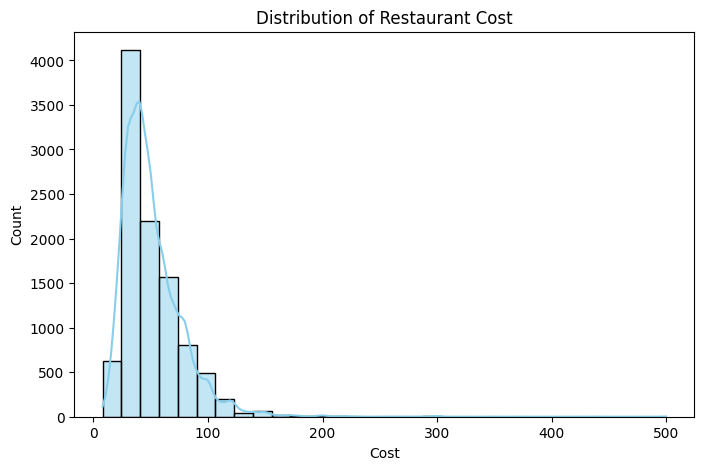

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['cost'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Restaurant Cost")
plt.xlabel("Cost")
plt.ylabel("Count")
plt.show()

C:\Users\IQ\AppData\Local\Temp\ipykernel_26968\925654673.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='rating_text', data=df, order=df['rating_text'].value_counts().index, palette='viridis')


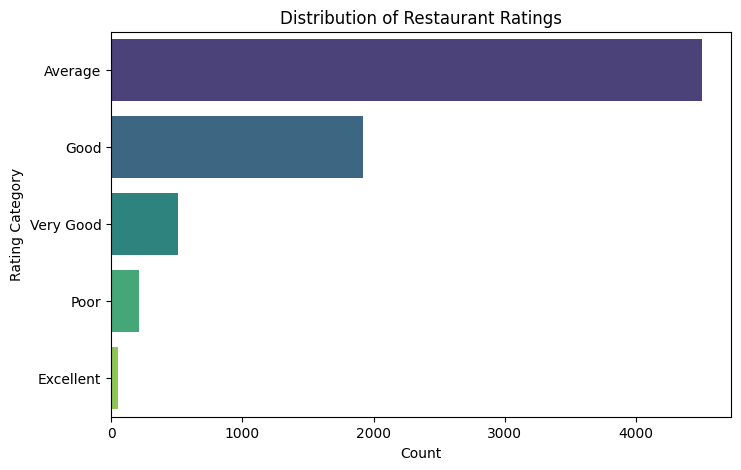

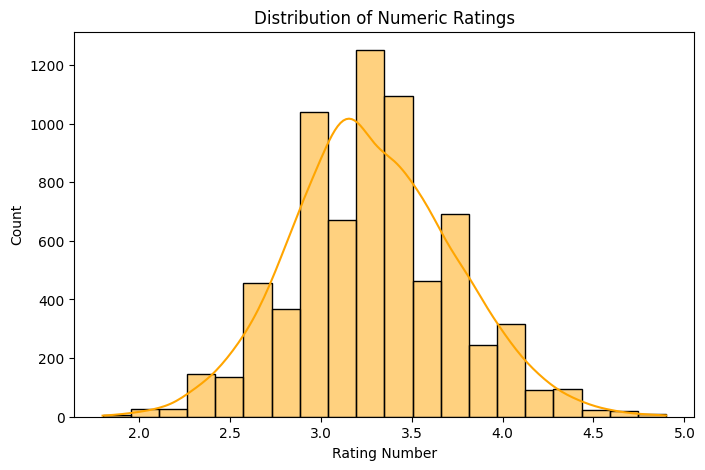

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(y='rating_text', data=df, order=df['rating_text'].value_counts().index, palette='viridis')
plt.title("Distribution of Restaurant Ratings")
plt.xlabel("Count")
plt.ylabel("Rating Category")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df['rating_number'], bins=20, kde=True, color='orange')
plt.title("Distribution of Numeric Ratings")
plt.xlabel("Rating Number")
plt.ylabel("Count")
plt.show()


C:\Users\IQ\AppData\Local\Temp\ipykernel_26968\27182992.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='type', data=df, order=df['type'].value_counts().head(10).index, palette='mako')


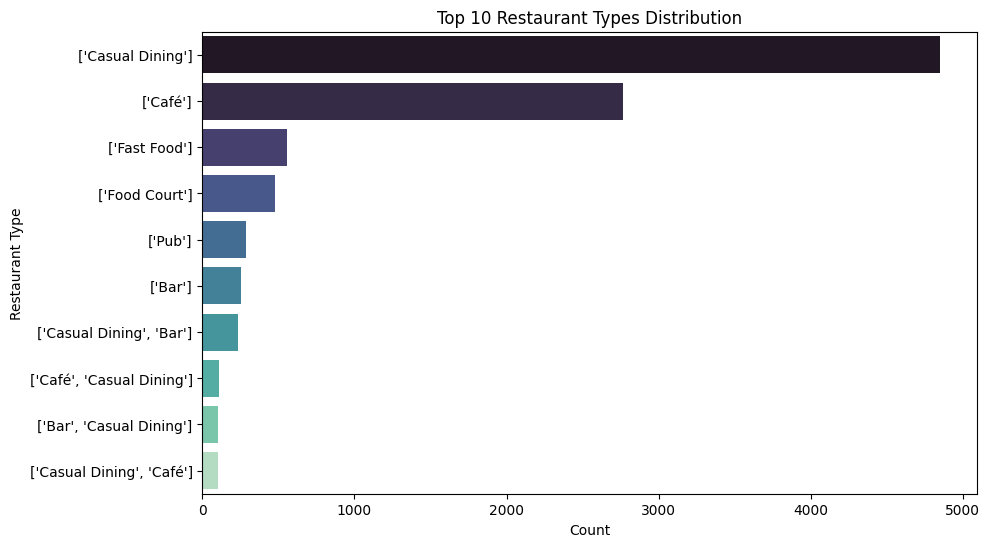

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(y='type', data=df, order=df['type'].value_counts().head(10).index, palette='mako')
plt.title("Top 10 Restaurant Types Distribution")
plt.xlabel("Count")
plt.ylabel("Restaurant Type")
plt.show()


In [ ]:
df = pd.read_csv('zomato_df_final_data.csv')
correlation = df['cost'].corr(df['votes'])
print(f'Correlation between cost and votes: {correlation}')

Correlation between cost and votes: 0.27021555258278407


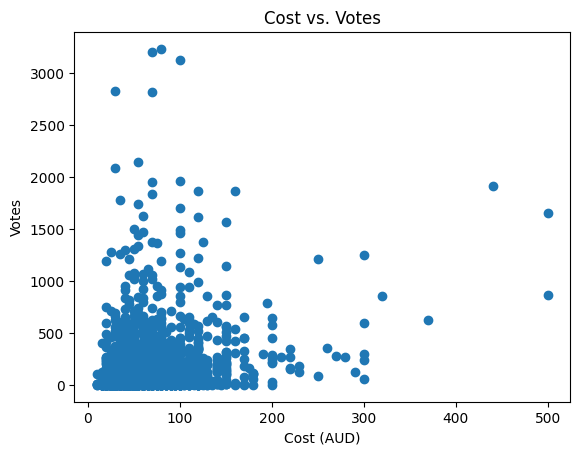

In [ ]:
plt.scatter(df['cost'], df['votes'])
plt.xlabel('Cost (AUD)')
plt.ylabel('Votes')
plt.title('Cost vs. Votes')
plt.show()

C:\Users\IQ\AppData\Local\Temp\ipykernel_26968\574274396.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='cuisine', y='rating_number', data=df, palette='viridis', ci='sd')
C:\Users\IQ\AppData\Local\Temp\ipykernel_26968\574274396.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cuisine', y='rating_number', data=df, palette='viridis', ci='sd')


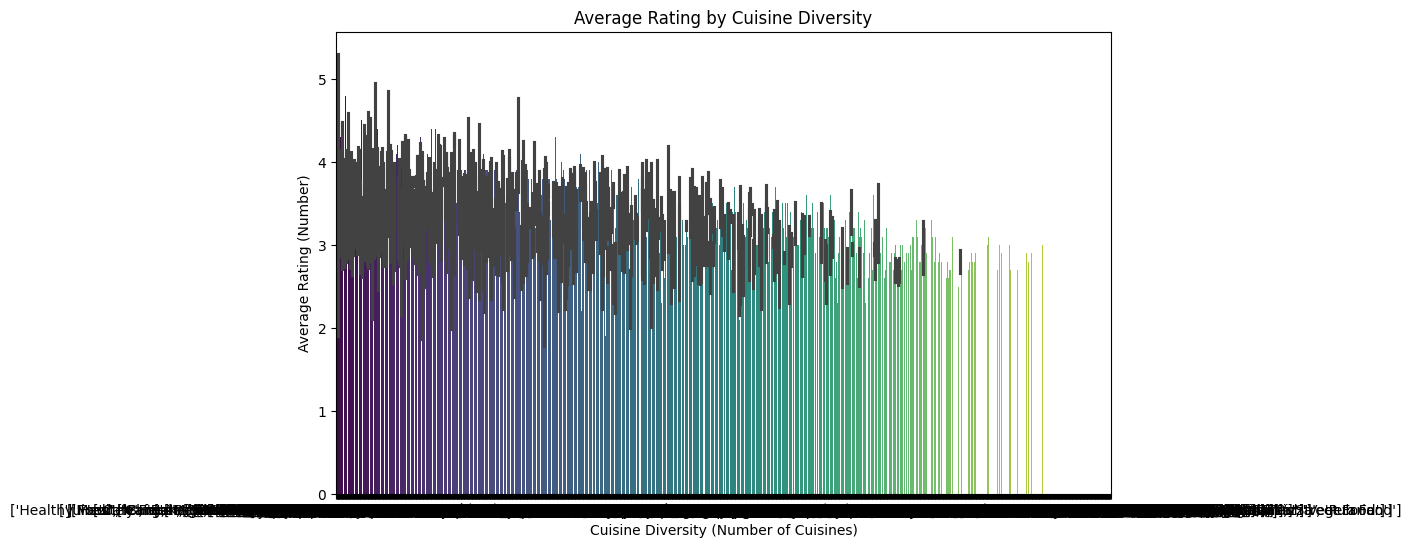

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='cuisine', y='rating_number', data=df, palette='viridis', ci='sd')
plt.xlabel('Cuisine Diversity (Number of Cuisines)')
plt.ylabel('Average Rating (Number)')
plt.title('Average Rating by Cuisine Diversity')
plt.show()


In [ ]:
with open("sydney .geojson") as f:
    data = json.load(f)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(data["features"])

# Check columns
print(gdf.columns)


Index(['geometry', 'SSC_CODE', 'SSC_NAME', 'CONF_VALUE', 'SQKM'], dtype='object')


In [ ]:
cuisine_name = 'Japanese'
df['has_cuisine'] = df['cuisine'].apply(lambda x: cuisine_name in x)

suburb_counts = df.groupby('subzone')['has_cuisine'].sum().reset_index()
suburb_counts.columns = ['SSC_NAME', 'count']


In [ ]:
merged = gdf.merge(suburb_counts, on='SSC_NAME', how='left')
merged['count'] = merged['count'].fillna(0)

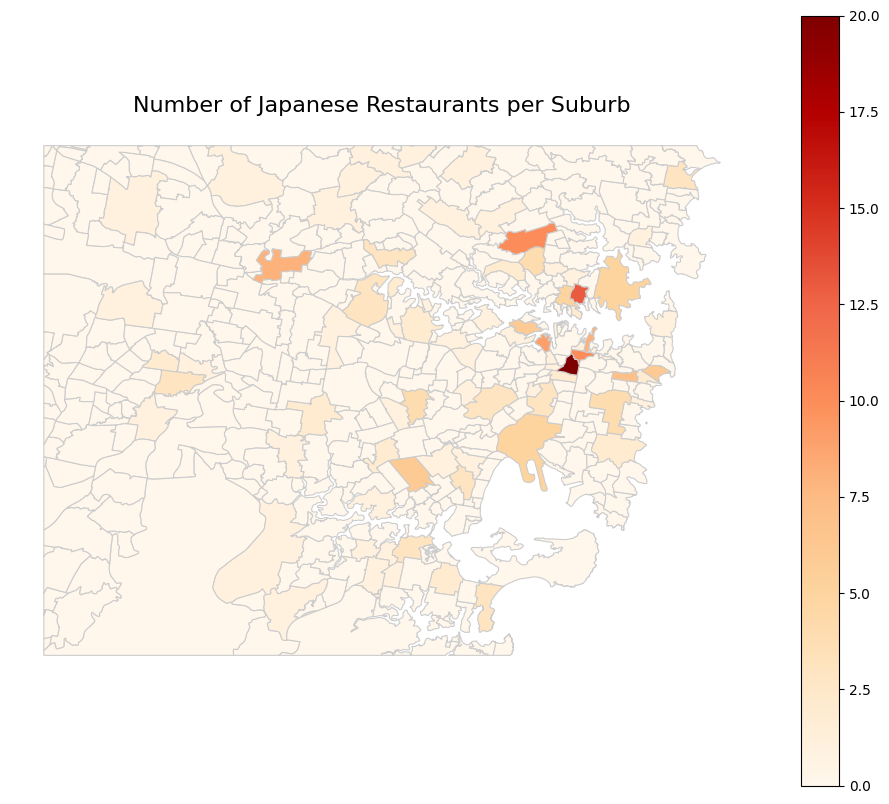

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
merged.plot(column='count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title(f'Number of {cuisine_name} Restaurants per Suburb', fontdict={'fontsize': 16})
ax.axis('off')

plt.show()

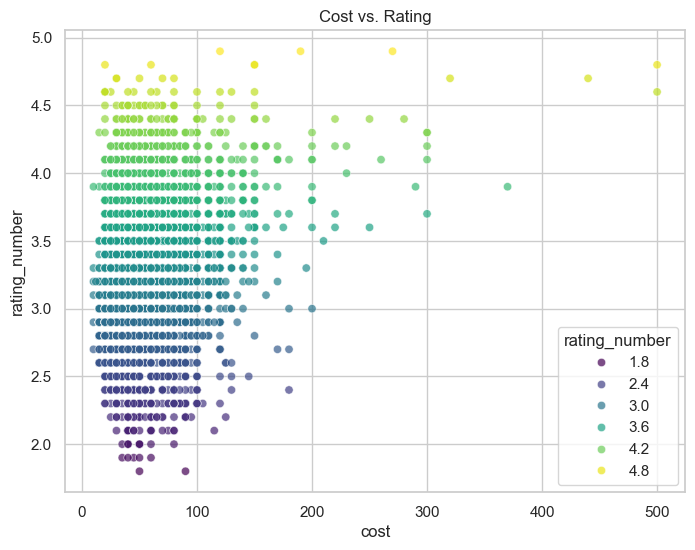

In [ ]:

sns.set(style="whitegrid")
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='cost', y='rating_number', hue='rating_number', palette='viridis', alpha=0.7)
plt.title("Cost vs. Rating")
plt.show()

### Why This Insight and Plot?

Limitation of Static Plot: A static scatter plot (e.g., seaborn.scatterplot) for cost vs. rating shows the trend but doesn’t let you hover to see restaurant details (like title, subzone, or cuisine) or zoom into dense areas, making it hard to explore specific outliers or clusters.
Interactive Advantage: plotly.express.scatter creates an interactive plot where you can hover to see restaurant details, zoom, and pan. The color by rating_text and size by votes add visual depth, making patterns (e.g., high-cost, high-rated restaurants) easier to spot.
Visual Appeal: Uses Plotly’s default vibrant colors (good for light/dark themes) and includes a title and axis labels for clarity.
Project Fit: This fits the "Interactive Visualisation" part of the EDA section, addressing the assignment’s call for an interactive plot to explore key variables and overcome static plot limitations.

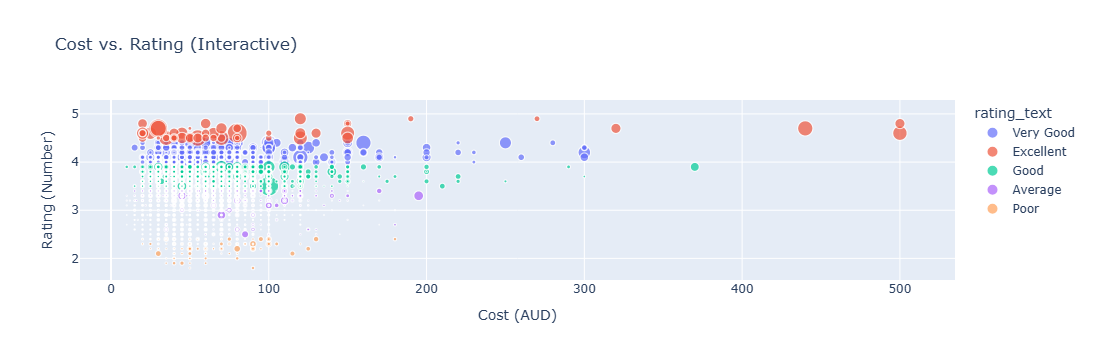

In [ ]:
import pandas as pd
import plotly.express as px
df = pd.read_csv('zomato_df_final_data.csv')
df = df.dropna(subset=['cost', 'rating_number'])
fig = px.scatter(df, x='cost', y='rating_number', color='rating_text', size='votes', hover_data=['title', 'subzone'], title='Cost vs. Rating (Interactive)')
fig.update_layout(xaxis_title='Cost (AUD)', yaxis_title='Rating (Number)')
fig.show()